In [1]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..', '..'))
print os.getcwd()

/Users/eharkin/Documents/projects/5HTGIF


In [2]:
import warnings
import re

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import numpy as np
from sklearn.model_selection import ParameterGrid

from grr.Simulation import GIFnet_Simulation
from grr.Tools import PSTH, raiseExpectedGot, timeToIndex, reprint
from grr.CurveFit import plot_linear_fit

In [3]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))
plt.rc('text', usetex=False)
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'GIF_network')

In [4]:
DATA_PATH = os.path.join('data', 'simulations', 'GIF_network', 'step_input')

sim_dict = {'Circuit': [], 'Mod type': [], 'Condition': [], 'Rep': [], 'Model': []}

for network_model in ['DRN_base', 'DRN_noIA', 'DRN_fixedIA', 'mPFC_base']:
    for gaba_condition in os.listdir(os.path.join(DATA_PATH, network_model)):
        for fname in os.listdir(os.path.join(DATA_PATH, network_model, gaba_condition)):
            if fname.endswith(('hdf5', 'h5')):

                sim_dict['Circuit'].append(
                    re.search(r'(DRN|mPFC)_(.*)', network_model).groups()[-2]
                )
                sim_dict['Mod type'].append(
                    re.search(r'(DRN|mPFC)_(.*)', network_model).groups()[-1]
                )
                sim_dict['Condition'].append(
                    re.search(r'GABA_(.*)', gaba_condition).groups()[-1]
                )
                sim_dict['Rep'].append(
                    int(re.search(r'rep([0-9]+)', fname).groups()[-1])
                )
                sim_dict['Model'].append(
                    GIFnet_Simulation(
                        os.path.join(DATA_PATH, network_model, gaba_condition, fname), 
                        mode = 'r'
                    )
                )

sim_df = pd.DataFrame(sim_dict).sort_values(['Mod type', 'Condition', 'Rep'])
sim_df.reset_index(inplace=True, drop=True)
sim_df.head()

,Circuit,Condition,Mod type,Model,Rep
0,DRN,KO,base,[ser],0
1,mPFC,KO,base,[ser],0
2,DRN,KO,base,[ser],1
3,mPFC,KO,base,[ser],1
4,DRN,KO,base,[ser],2


In [5]:
sim_df['Principal PSTH'] = None
sim_df['Principal PSTH'] = sim_df['Principal PSTH'].astype(object)
sim_df['GABA PSTH'] = None
sim_df['GABA PSTH'] = sim_df['GABA PSTH'].astype(object)

In [6]:
PSTH_width = 50.

for i in range(sim_df.shape[0]):
    reprint('Computing PSTH {:.1f}%'.format(100. * i / sim_df.shape[0]))
    
    # Get PSTH from 5HT population.
    sim_df.at[i, 'Principal PSTH'] = np.empty((
        sim_df.loc[i, 'Model'].get_no_sweeps(), 
        sim_df.loc[i, 'Model'].get_no_timesteps()
    ))
    for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
        sim_df.loc[i, 'Principal PSTH'][sweep_no, :] = PSTH(
            sim_df.loc[i, 'Model'].ser_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            sim_df.loc[i, 'Model'].get_no_ser_neurons()
        )
    
    # Get PSTHs from GABA population.
    if sim_df.loc[i, 'Condition'] != 'KO':
        sim_df.at[i, 'GABA PSTH'] = np.empty((
            sim_df.loc[i, 'Model'].get_no_sweeps(), 
            sim_df.loc[i, 'Model'].get_no_timesteps()
        ))
        for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
            sim_df.loc[i, 'GABA PSTH'][sweep_no, :] = PSTH(
                sim_df.loc[i, 'Model'].gaba_spktrains[sweep_no, ...].sum(axis = 0),
                PSTH_width,
                sim_df.loc[i, 'Model'].get_no_gaba_neurons()
            )
    else:
        sim_df.loc[i, 'GABA PSTH'] = None
        continue

print('\nDone!')

Computing PSTH 99.0%
Done!


In [7]:
psth_dict = {'Circuit': [], 'Mod type': [], 'Condition': [], 'Principal PSTH': [], 'GABA PSTH': []}
for circuit in sim_df['Circuit'].unique():
    for modtype in sim_df.loc[sim_df['Circuit'] == circuit, 'Mod type'].unique():
        for cond in sim_df.loc[(sim_df['Circuit'] == circuit) & (sim_df['Mod type'] == modtype), 'Condition'].unique():
            psth_dict['Circuit'].append(circuit)
            psth_dict['Mod type'].append(modtype)
            psth_dict['Condition'].append(cond)
            psth_dict['Principal PSTH'].append(np.array(
                sim_df.loc[(sim_df['Circuit'] == circuit) & (sim_df['Condition'] == cond) & (sim_df['Mod type'] == modtype), 'Principal PSTH'].tolist()
            ))
            psth_dict['GABA PSTH'].append(np.array(
                sim_df.loc[(sim_df['Circuit'] == circuit) & (sim_df['Condition'] == cond) & (sim_df['Mod type'] == modtype), 'GABA PSTH'].tolist()
            ))
psth_df = pd.DataFrame(psth_dict)
del psth_dict

In [8]:
psth_df.head()

,Circuit,Condition,GABA PSTH,Mod type,Principal PSTH
0,DRN,KO,"[None, None, None, None, None, None, None, Non...",base,"[[[0.43333333333333335, 0.43333333333333335, 0..."
1,DRN,base,"[[[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1...",base,"[[[0.2, 0.23333333333333334, 0.233333333333333..."
2,DRN,noinput,"[[[1.7000000000000002, 1.7000000000000002, 1.7...",base,"[[[0.2666666666666667, 0.2666666666666667, 0.2..."
3,DRN,KO,"[None, None, None, None, None, None, None, Non...",fixedIA,"[[[0.2, 0.2, 0.23333333333333334, 0.2333333333..."
4,DRN,base,"[[[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1...",fixedIA,"[[[0.23333333333333334, 0.23333333333333334, 0..."


In [9]:
def select_PSTH_dataset(dframe, circuit, condition, mod_type, psth_type='Principal PSTH'):
    return dframe.loc[
        (dframe['Circuit'] == circuit)
        & (dframe['Condition'] == condition) 
        & (dframe['Mod type'] == mod_type), 
        psth_type
    ].item()

In [10]:
def get_step_amplitudes(simulation, step_start_time):
    step_start_ind = timeToIndex(step_start_time, 0.1)[0]
    baseline = simulation['ser/examples/I'][..., :step_start_ind].mean()
    return simulation['ser/examples/I'][..., step_start_ind:].mean(axis=2).mean(axis=1) - baseline

def get_pointwise_gain(psth_arr, step_amplitudes, baseline_start_time, step_start_time, cov=False, dt=0.1):
    """
    Returns
    -------
    (gain, intercept) if cov = False, or (gain, intercept, parameter_covariance_matrix) if cov=True.
    
    """
    assert np.ndim(psth_arr) == 3
    assert np.ndim(step_amplitudes) == 1
    assert np.shape(psth_arr)[1] == len(step_amplitudes)
    
    step_start_ind = timeToIndex(step_start_time, dt)[0]
    step_response = psth_arr[..., step_start_ind:]
    mean_step_response = step_response.mean(axis=0)
    
    baseline_activity = psth_arr[..., timeToIndex(baseline_start_time, dt)[0]:step_start_ind]
    mean_baseline_activity = baseline_activity.mean(axis=0).mean(axis=1)  # Average over sweeps and time.
    assert np.ndim(mean_baseline_activity) == 1
    assert len(mean_baseline_activity) == mean_step_response.shape[0]
    
    coeffs, V = np.polyfit(step_amplitudes, mean_step_response - mean_baseline_activity[:, np.newaxis], deg=1, cov=cov)
    
    if cov:
        return coeffs[0, :], coeffs[1, :], V
    else:
        return coeffs[0, :], coeffs[1, :]

In [11]:
step_amplitudes = get_step_amplitudes(sim_df.loc[0, 'Model'], 1000.)

In [12]:
def plot_lines_cmap(x, y, cmap, start=0., stop=1., ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()
    
    colors = cmap(np.linspace(start, stop, np.shape(y)[1]))
    for i in range(np.shape(y)[1]):
        ax.plot(x, y[:, i], color=colors[i], **pltargs)

In [ ]:
def gain_uncertainty_plot(t_vec, )

IOError: [Errno 13] Permission denied: 'figs/ims/writeup/GIF_network/control_gain_illustration.png'

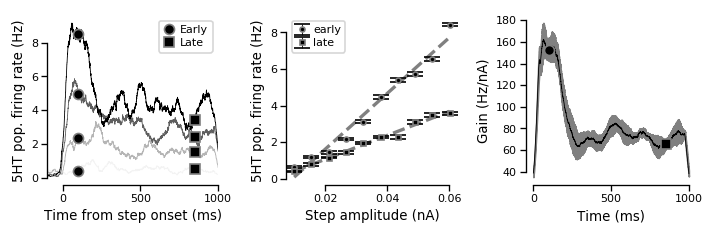

In [14]:
ser_ctrl_psth = select_PSTH_dataset(psth_df, 'DRN', 'KO', 'base', 'Principal PSTH')

ebar_params = {'ls': 'none', 'capsize': 5, 'ecolor': 'k', 'markersize': 3}
markeredgecolor='gray'
cmap = plt.get_cmap('Greys')
stim_start_time = 1000.
peak_ind = 11000
steady_ind = 18500
t_vec = sim_df['Model'][0].get_t_vec() - stim_start_time

spec = gs.GridSpec(1, 3)

plt.figure(figsize=(6, 2))

plt.subplot(spec[:, 0])
plot_lines_cmap(t_vec, ser_ctrl_psth[0, ::3, :].T, cmap, start=0.1)
plt.plot(
    [peak_ind * 0.1 - stim_start_time] * 4, 
    ser_ctrl_psth[0, ::3, peak_ind], 
    'ko', label='Early', markeredgecolor=markeredgecolor
)
plt.plot(
    [steady_ind * 0.1 - stim_start_time] * 4, 
    ser_ctrl_psth[0, ::3, steady_ind], 
    'ks', label='Late', markeredgecolor=markeredgecolor
)
plt.xlim(-100., 1000.)
plt.xlabel('Time from step onset (ms)')
plt.ylabel('5HT pop. firing rate (Hz)')
plt.legend()

plt.subplot(spec[:, 1])
plt.errorbar(
    marker='o',
    color='k',
    markeredgecolor=markeredgecolor,
    x=step_amplitudes,
    y=ser_ctrl_psth[..., peak_ind].mean(axis=0), 
    yerr=ser_ctrl_psth[..., peak_ind].std(axis=0)/np.sqrt(ser_ctrl_psth.shape[0]),
    label='early',
    **ebar_params
)
plt.errorbar(
    marker='s',
    color='k',
    markeredgecolor=markeredgecolor,
    x=step_amplitudes,
    y=ser_ctrl_psth[..., steady_ind].mean(axis=0), 
    yerr=ser_ctrl_psth[..., steady_ind].std(axis=0)/np.sqrt(ser_ctrl_psth.shape[0]),
    label='late',
    **ebar_params
)
plot_linear_fit(step_amplitudes, ser_ctrl_psth[..., peak_ind].mean(axis=0), zorder=-1, lw=2, ls='--', color='gray')
plot_linear_fit(step_amplitudes, ser_ctrl_psth[..., steady_ind].mean(axis=0), zorder=-1, lw=2, ls='--', color='gray')
plt.ylabel('5HT pop. firing rate (Hz)')
plt.xlabel('Step amplitude (nA)')
plt.legend()

plt.subplot(spec[:, 2])

ser_gain, _, ser_cov = get_pointwise_gain(ser_ctrl_psth, step_amplitudes, 500., stim_start_time, cov=True)
ser_uncertainty = np.sqrt(ser_cov[0, 0, :])
del ser_cov

plt.fill_between(
    t_vec[timeToIndex(stim_start_time, 0.1)[0]:],
    ser_gain - ser_uncertainty,
    ser_gain + ser_uncertainty,
    color='gray'
)
plt.plot(
    t_vec[timeToIndex(stim_start_time, 0.1)[0]:], 
    ser_gain,
    'k-'
)
plt.plot(
    [peak_ind * 0.1 - stim_start_time], 
    [ser_gain[peak_ind - timeToIndex(stim_start_time, 0.1)[0]] ],
    'ko',
    markeredgecolor=markeredgecolor
)
plt.plot(
    [steady_ind * 0.1 - stim_start_time], 
    [ser_gain[steady_ind - timeToIndex(stim_start_time, 0.1)[0]]],
    'ks',
    markeredgecolor=markeredgecolor
)
plt.ylabel('Gain (Hz/nA)')
plt.xlabel('Time (ms)')

sns.despine(trim=True)

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'control_gain_illustration.png'))

del ser_ctrl_psth, ser_gain

In [15]:
Base_gain = get_pointwise_gain(
    select_PSTH_dataset(psth_df, 'DRN', 'KO', 'base', 'Principal PSTH'), 
    step_amplitudes, 
    500., 
    stim_start_time
)[0]
NoIA_gain = get_pointwise_gain(
    select_PSTH_dataset(psth_df, 'DRN', 'KO', 'noIA', 'Principal PSTH'), 
    step_amplitudes, 
    500., 
    stim_start_time
)[0]
FixedIA_gain = get_pointwise_gain(
    select_PSTH_dataset(psth_df, 'DRN', 'KO', 'fixedIA', 'Principal PSTH'), 
    step_amplitudes, 
    500., 
    stim_start_time
)[0]

plt.subplot(111)
plt.plot(
    t_vec[timeToIndex(stim_start_time, 0.1)[0]:], 
    Base_gain,
    color='blue',
    label='Control'
)
plt.plot(
    t_vec[timeToIndex(stim_start_time, 0.1)[0]:], 
    NoIA_gain,
    color='gray',
    label='$I_A$ KO'
)
plt.plot(
    t_vec[timeToIndex(stim_start_time, 0.1)[0]:], 
    FixedIA_gain,
    color='blue',
    ls='--',
    label='High $I_A$'
)
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'IA_gain_illustration.png'))

del Base_gain, FixedIA_gain, NoIA_gain

IndexError: too many indices for array

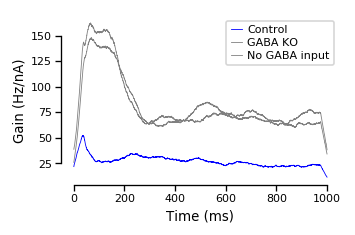

In [15]:
base_gain = get_pointwise_gain(
    select_PSTH_dataset(psth_df, 'DRN', 'base', 'base', 'Principal PSTH'), 
    step_amplitudes, 
    500., 
    stim_start_time
)[0]
gaba_ko_gain = get_pointwise_gain(
    select_PSTH_dataset(psth_df, 'DRN', 'KO', 'base', 'Principal PSTH'), 
    step_amplitudes, 
    500., 
    stim_start_time
)[0]
gaba_noinput_gain = get_pointwise_gain(
    select_PSTH_dataset(psth_df, 'DRN', 'noinput', 'base', 'Principal PSTH'), 
    step_amplitudes, 
    500., 
    stim_start_time
)[0]

plt.subplot(111)
plt.plot(
    t_vec[timeToIndex(stim_start_time, 0.1)[0]:], 
    base_gain,
    color='blue',
    label='Control'
)
plt.plot(
    t_vec[timeToIndex(stim_start_time, 0.1)[0]:], 
    gaba_ko_gain,
    color='gray',
    label='GABA KO'
)
plt.plot(
    t_vec[timeToIndex(stim_start_time, 0.1)[0]:], 
    gaba_noinput_gain,
    color='gray',
    label='No GABA input'
)
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'som_gain_illustration.png'))

del base_gain, gaba_ko_gain

# Inspect PFC

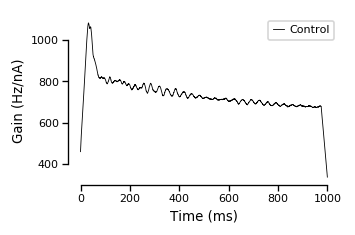

In [16]:
mpfc_gain = get_pointwise_gain(
    select_PSTH_dataset(psth_df, 'mPFC', 'KO', 'base', 'Principal PSTH'), 
    step_amplitudes, 
    500., 
    stim_start_time
)[0]


plt.subplot(111)
plt.plot(
    t_vec[timeToIndex(stim_start_time, 0.1)[0]:], 
    mpfc_gain,
    color='k',
    label='Control'
)
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'mpfc_gain_illustration.png'))

del mpfc_gain

In [17]:
mpfc_psth = select_PSTH_dataset(psth_df, 'mPFC', 'KO', 'base', 'Principal PSTH')

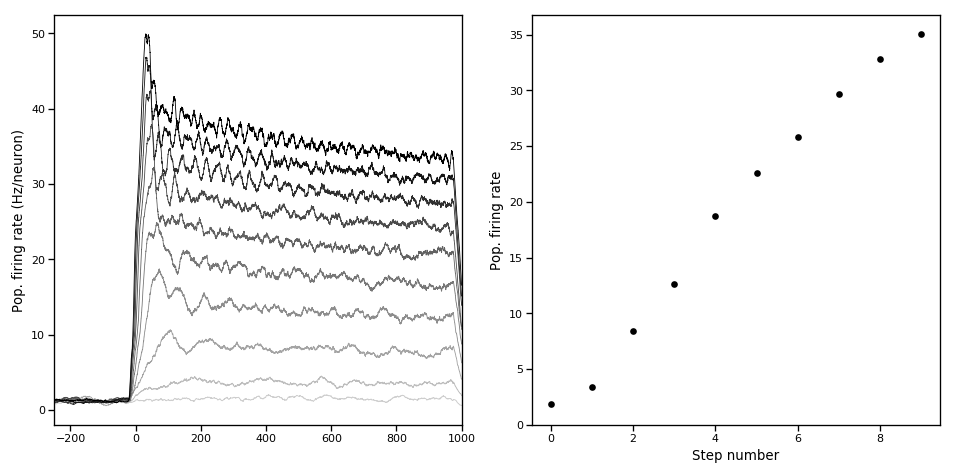

In [22]:
plt.figure(figsize=(8, 4))

plt.subplot(121)
plot_lines_cmap(t_vec, mpfc_psth[0, ::1, :].T, cmap, start=0.3)
plt.xlim(-250, 1000)
plt.ylabel('Pop. firing rate (Hz/neuron)')

plt.subplot(122)
plt.plot(mpfc_psth[0, :, 15000], 'k.')
plt.ylim(0, plt.ylim()[1])
plt.ylabel('Pop. firing rate')
plt.xlabel('Step number')

plt.tight_layout()

plt.show()

In [ ]:
sweep_no = 5

plt.subplot(111)
plt.fill_between(t_vec, mpfc_psth[:, sweep_no, :].mean(axis=0) - mpfc_psth[:, sweep_no, :].std(axis=0), mpfc_psth[:, sweep_no, :].mean(axis=0) + mpfc_psth[:, sweep_no, :].std(axis=0))
plot_lines_cmap(t_vec, mpfc_psth[0, ::1, :].T, cmap, start=0.3)
plt.xlim(-250, 1000)
plt.ylabel('Pop. firing rate (Hz/neuron)')

# Inspect SOM

In [ ]:
gaba_gain = get_pointwise_gain(
    select_PSTH_dataset(psth_df, 'DRN', 'base', 'base', 'GABA PSTH'), 
    step_amplitudes, 
    500., 
    stim_start_time
)[0]


plt.subplot(111)
plt.plot(
    t_vec[timeToIndex(stim_start_time, 0.1)[0]:], 
    gaba_gain,
    color='k',
    label='Control'
)
plt.xlabel('Time (ms)')
plt.ylabel('Gain (Hz/nA)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'som_neuron_gain_illustration.png'))

del gaba_gain